<h3>Algorithmic Machine Learning Challenge</h3>
<h1>Plankton Image Classification</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

<div class="alert alert-warning">Corentin RAFFLIN </div>

# Overview

For this problem of Image Classification, we will use “Deep Learning” methods. The model will be a (convolutional) neural network in which features are learned from image data alone. 
* An advantage of this approach is to let the neural network choose the features. Furthermore this approach is good when we have an important quantity of samples and is especially efficient for image recognition.
* A disadvantage is that the computational cost can be high depending on the number of sample as well as the size of the images. Furthermore, neural networks do not deal well with imbalanced data set.

It would have been possible to deal with this problem using the pre-computed features extracted from the images or by extracting our own features from the images and train a classifier (SVC, Decision Trees...) with these features.

In [ ]:
# Install the library we can use for under and over-sampling, as well as a library for a CNN
!pip3 install --user 'imblearn'
!pip3 install --user 'keras'

In [ ]:
#Diverses libraries
%matplotlib inline
import os
import sys
import re
import random
from time import time

# Data and plotting imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

#Image and files libraries
import zipfile
from io import BytesIO
from PIL import Image, ImageOps, ImageFilter

#Neural network libraries
from sklearn import preprocessing, model_selection, metrics
from sklearn.neural_network import MLPClassifier

#Over and under-sampling libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

#Import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


<div class="">
    <h3>1. Data Exploration </h3>
</div>

<h4> Importing the data </h4>

In [ ]:
def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}

def printMissing(dataframe):
    ''' Printing the missing data in the dataframe with the total of missing and the corresponding percentage '''
    total = dataframe.isnull().sum().sort_values(ascending=False)
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data[missing_data['Total']>0])

In [ ]:
#Importing the meta-data to get the labels 
meta = pd.read_csv('/mnt/datasets/plankton/flowcam/meta.csv', sep=',', header=0)
#taxo = pd.read_csv('/mnt/datasets/plankton/flowcam/taxo.csv', sep=',', header=0)
#features_native=pd.read_csv('/mnt/datasets/plankton/flowcam/features_native.csv.gz', sep=',', header=0)
#features_skimages=pd.read_csv('/mnt/datasets/plankton/flowcam/features_skimage.csv.gz', sep=',', header=0)

In [ ]:
#Extracting the images
img_files = extract_zip_to_memory("/mnt/datasets/plankton/flowcam/imgs.zip")
print("Number of images :", len(img_files))

Number of images : 243610


<h4> Exploring the taxonomy (level 2) </h4>

In [ ]:
#we only care about the id (to do the mapping with the image) and the output "level2"
labelL2 = meta.copy()
labelL2.drop(labelL2.columns.difference(['objid','level2']), 1, inplace=True)

In [ ]:
#Print all level2 possible values
print(labelL2.level2.sort_values().unique())
print("Number of categories level 2 (including missing) : ", len(labelL2.level2.sort_values().unique()))

['Annelida' 'Asterionellopsis' 'Bacteriastrum' 'Ceratocorys horrida'
 'Chaetoceros' 'Codonaria' 'Codonellopsis (Dictyocystidae)' 'Copepoda'
 'Coscinodiscids' 'Cyttarocylis' 'Dictyocysta' 'Dinophysiales' 'Hemiaulus'
 'Lithodesmioides' 'Neoceratium' 'Odontella (Mediophyceae)' 'Pleurosigma'
 'Protoperidinium' 'Retaria' 'Rhabdonella' 'Rhizosolenids' 'Stenosemella'
 'Thalassionema' 'Tintinnidiidae' 'Undellidae' 'Xystonellidae' 'artefact'
 'badfocus (artefact)' 'centric' 'chainlarge' 'detritus' 'egg (other)'
 'feces' 'multiple (other)' 'nauplii (Crustacea)' 'pollen' 'rods' 'silks'
 'tempChaetoceros danicus' nan]
Number of categories level 2 (including missing) :  40


We notice missing values "nan" as well as some values that we may want to remove : "artefact", "badfocus (artefact)" as well as "multiple (other)", "egg (other)". We will remove the first two values later on, but the last two can still represent things we want to identify so we will keep them. This step depends on what we want from our classifier.

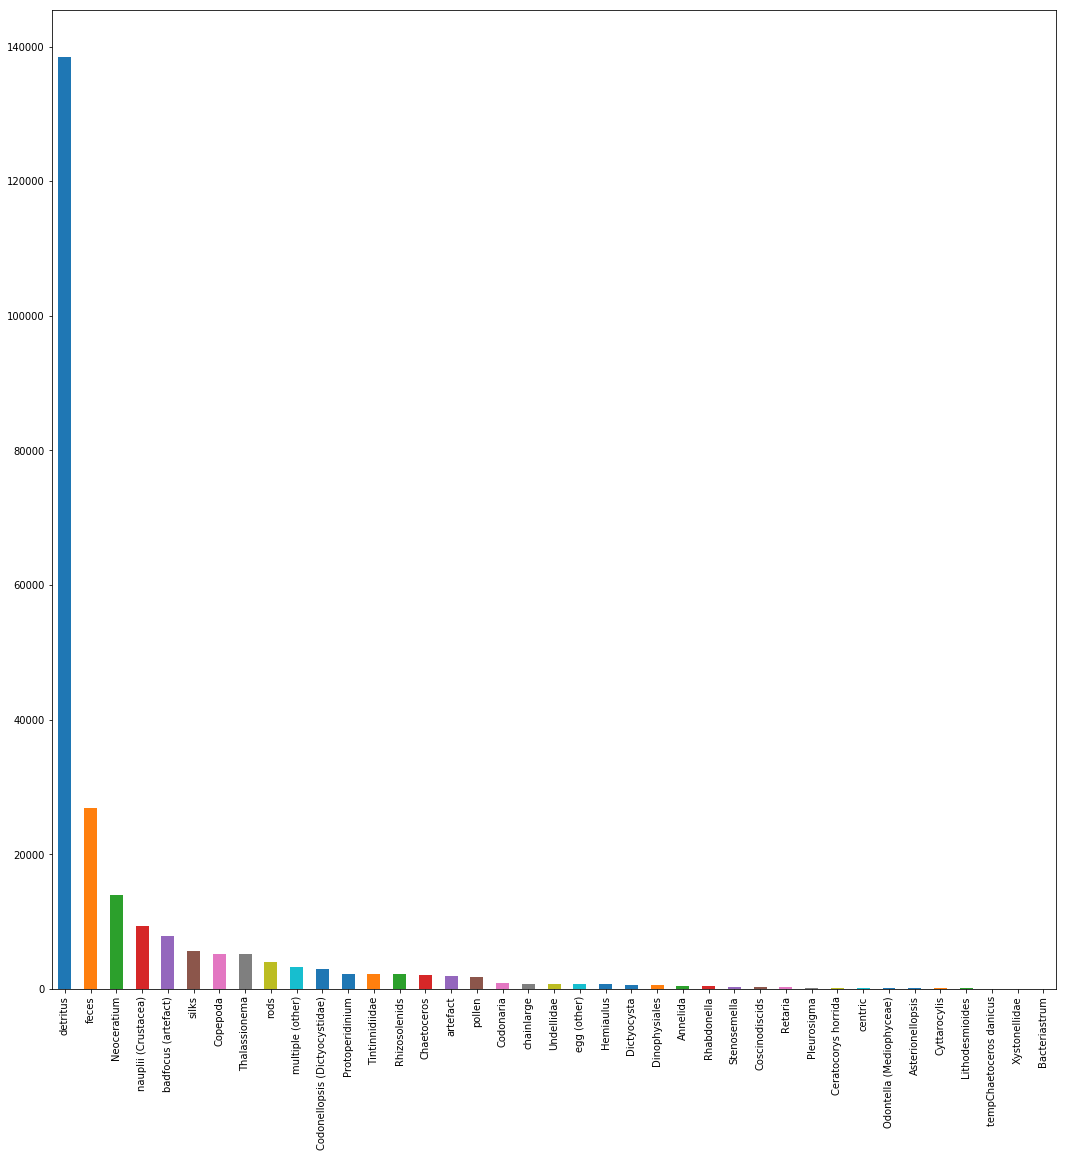

In [ ]:
#plotting the distribution of level 2 values 
fig, ax1 = plt.subplots(1, 1, figsize= (18,18))
meta['level2'].value_counts().plot(kind='bar', ax=ax1)

We notice an important majority of "detritus", followed by "feces". At the opposite, a lot of samples are rare like "Xystonellidae" and "Bacteriastrum" to give a few, it may be useful to do some data augmentation for these images to improve the accuracy of the classifier.

In [ ]:
countDF = pd.DataFrame()
countDF['Count'] = labelL2['level2'].value_counts()
countDF['Percentage'] = labelL2['level2'].value_counts(normalize=True) * 100
display(countDF)

,Count,Percentage
detritus,138439,57.063069
feces,26936,11.102730
Neoceratium,14014,5.776420
nauplii (Crustacea),9293,3.830475
badfocus (artefact),7848,3.234861
silks,5629,2.320213
Copepoda,5141,2.119065
Thalassionema,5117,2.109172
rods,4044,1.666893
multiple (other),3261,1.344149


This table really shows how imbalanced is our dataset, with one class representing 57% of the data set while around twenty classes represent less than 1% of the data set. We will therefore need to solve this issue. 

<h4> Visualizing some images </h4>

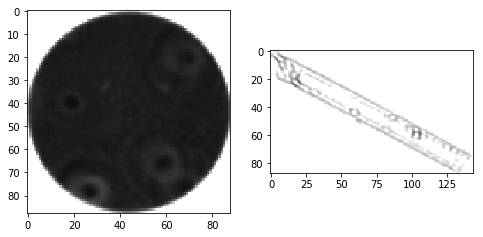

In [ ]:
#plotting examples of image for "artefact" and "badfocus (artefact)"
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))
idArtefact = int(labelL2[labelL2["level2"]=="artefact"].iloc[0].objid)
idBadFocus = int(labelL2[labelL2["level2"]=="badfocus (artefact)"].iloc[0].objid)
img_art = Image.open(img_files['imgs/' + str(idArtefact) +'.jpg'])
img_badfocus = Image.open(img_files['imgs/' + str(idBadFocus) + '.jpg'])
ax1.imshow(img_art)
ax2.imshow(img_badfocus)
plt.show()

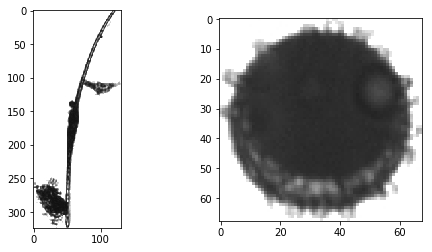

In [ ]:
#plotting examples of image for "multiple (other)" and "egg (other)"
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))
idMultiple = int(labelL2[labelL2["level2"]=="multiple (other)"].iloc[0].objid)
idEgg = int(labelL2[labelL2["level2"]=="egg (other)"].iloc[0].objid)
img_multiple = Image.open(img_files['imgs/' + str(idMultiple) +'.jpg'])
img_egg = Image.open(img_files['imgs/' + str(idEgg) + '.jpg'])
ax1.imshow(img_multiple)
ax2.imshow(img_egg)
plt.show()

We notice that the egg and the artefact look a lot alike, the classifier will sure better identify the eggs without the artifacts in the data set. At the end, it depends if we want also to be able to identify artefact or not, we will assume that we do not want them. Maybe we could remove other classes that do not represent a (single) plankton but we decided to let the other ones.

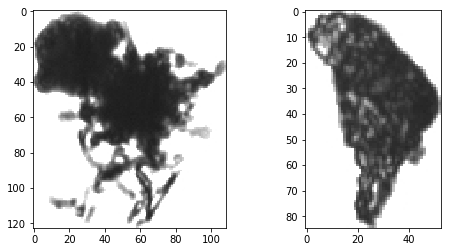

In [ ]:
#plotting examples of image for "detritus" and "feces"
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))
idDetritus = int(labelL2[labelL2["level2"]=="detritus"].iloc[0].objid)
idFeces = int(labelL2[labelL2["level2"]=="feces"].iloc[0].objid)
img_detritus = Image.open(img_files['imgs/' + str(idDetritus) +'.jpg'])
img_feces = Image.open(img_files['imgs/' + str(idFeces) + '.jpg'])
ax1.imshow(img_detritus)
ax2.imshow(img_feces)
plt.show()

<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

We did not use Pytorch's dataloader to process the data "on the fly". We are not sure of its utility but we believe that it may be simpler with a dataloader to apply a series of operations more efficiently on images.

<h4> Dealing with missing data </h4>

In [ ]:
printMissing(labelL2)

,Total,Percent
level2,1003,0.004117


In [ ]:
#find missing values
indices = np.where(labelL2['level2'].isna())[0]

#remove pictures without label 
for i in indices:
    objid = str(int(labelL2[labelL2.index == i].objid))
    labelL2.drop(labels=i, axis=0, inplace=True)
    del(img_files["imgs/" + objid  + ".jpg"])

<h4> Dealing with unwanted data (artefact) </h4>

In [ ]:
def removeImgs(level2, toKeep):
    ''' toKeep : number of images we want to keep in the level 2 class specified '''
    global labelL2
    indices = labelL2.index[labelL2['level2']==level2].tolist()
    random.shuffle(indices)  # shuffle so that we remove randomly the images
    toRemove = labelL2['level2'].value_counts()[level2]-toKeep #number of images to remove
    indices = indices[:toRemove]
    for i in indices:
        objid = labelL2[labelL2.index == i].objid
        objid = str(int(objid))
        labelL2.drop(labels=i, axis=0, inplace=True)
        del(img_files["imgs/" + objid  + ".jpg"])

In [ ]:
#We want to remove all (i.e toKeep=0) artefact and badfocus images
removeImgs("artefact", 0)
removeImgs("badfocus (artefact)", 0)

In [ ]:
#check that we have as many images as label
print("Same count :", len(img_files)==len(labelL2))

Same count : True


<h4> Dealing with the imbalanced dataset </h4>

Reference : https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18 

Several options can be chosen to deal with an imbalanced dataset : 
* Changing the <b> performance metric </b> : f1-score is one of the performance metrics adapted for an imbalanced dataset, and it is the one we will use at the end even though we will first make the dataset balanced.
* Changing the <b> classifier </b> : using a classifier that deals well with imbalanced dataset like Decision trees. But in our case we will use a neural network which is generally better for image classification.
* <b> Resampling </b> :
    * <b> undersampling </b> : to diminish the computational cost of our algorithm. Undersampling could lead to underfitting and poor generalization to the test set but could allow for more iterations. We could try to remove/deal with the images with the higher sizes to diminish the computation cost further more, but as we will resize the images it is not necessary, we could even lose some information by selecting only small images. There are many resampling module from Imblearn to remove samples from the majority class in an efficient way. We will later use imblearn's ClusterCentroids to make our dataset balanced but after having done some data augmentation.
    * <b> oversampling </b> : this can be done either by manually augmenting the data (in our case by flipping, rotating and so on) or by using some libraries (imblearn’s Synthetic Minority Oversampling Technique). SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model. It could be useful to deal with the classes that are under-representated like 'Bacteriastrum' (only 12 samples) but this would not work due to memory problem : the algorithm will try to generate samples to have as much 'Bacteriastrum' as the number of the majority class. Yet, we will still do some data augmentation by hand.
    

<h4> Undersampling </h4>

First, we will remove the images that are too much represented in our dataset, this will allow us to later load all the images into numpy arrays.
To avoid losing too much information we will still keep about 20,000 samples of the classes that go over this threshold. This is a number that could be optimized to see how it impact our classifier.

In [ ]:
start = time()
removeImgs("detritus", 20000)
removeImgs("feces", 20000)
print("Time :", time()-start)

Time : 1645.8982622623444


In [ ]:
countDF = pd.DataFrame()
countDF['Count'] = labelL2['level2'].value_counts()
countDF['Percentage'] = labelL2['level2'].value_counts(normalize=True) * 100
display(countDF)

,Count,Percentage
detritus,20000,18.598596
feces,20000,18.598596
Neoceratium,14014,13.032036
nauplii (Crustacea),9293,8.641838
silks,5629,5.234575
Copepoda,5141,4.780769
Thalassionema,5117,4.758451
rods,4044,3.760636
multiple (other),3261,3.032501
Codonellopsis (Dictyocystidae),2888,2.685637


The dataset is still clearly unbalanced, but we will do data augmentation followed by under sampling in the next part.

<h4> Exploring the size of the images </h4>

In [ ]:
#Opening every image for simplicity after
list_keys = list(img_files)
for img in list_keys:
    img_files[img] = Image.open(img_files[img])

In [ ]:
#load in a dataframe the height and width of images as well as the total size (height*width)
sizeDF = pd.DataFrame(columns=["height", "width", "total"])
for i, img in enumerate(img_files):
    np_arr = np.array(img_files[img])
    shape = np_arr.shape
    df = pd.DataFrame([[shape[0], shape[1], shape[0]*shape[1]]], columns = sizeDF.columns)
    sizeDF = sizeDF.append(df)
display(sizeDF.head())

,height,width,total
0,66,111,7326
0,174,210,36540
0,146,73,10658
0,89,31,2759
0,78,86,6708


In [ ]:
sizeDF = sizeDF.reset_index().drop(labels='index', axis=1)
# Cast each column to its datatype
sizeDF['height'] = sizeDF['height'].astype(np.int64, errors='ignore')
sizeDF['width'] = sizeDF['width'].astype(np.int64, errors='ignore')
sizeDF['total'] = sizeDF['total'].astype(np.int64, errors='ignore')

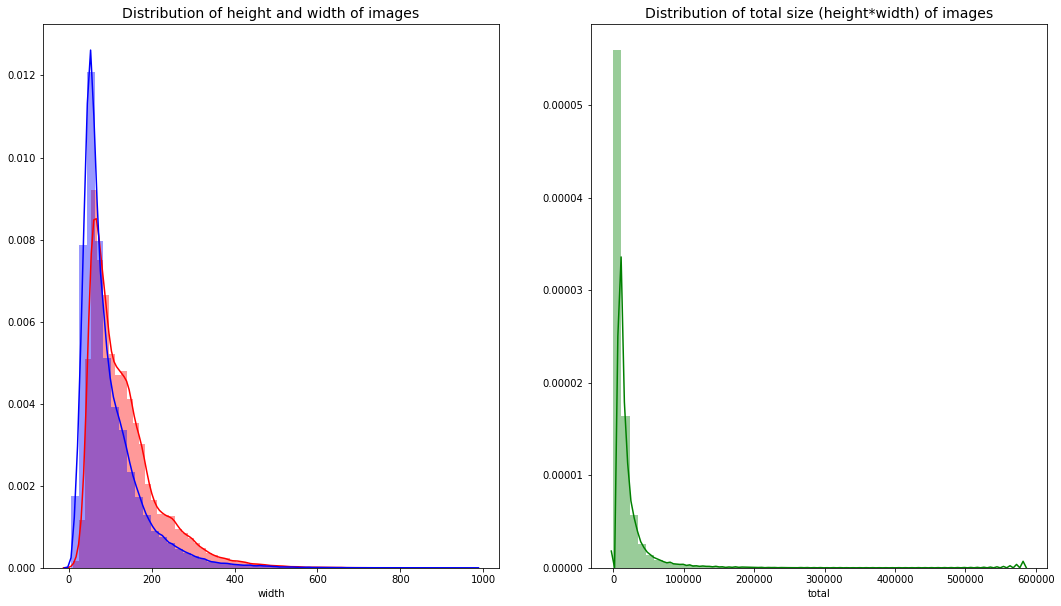

In [ ]:
#plot the distribution of the sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10))
sns.distplot(sizeDF['height'], color='r', ax=ax1, label="height")
sns.distplot(sizeDF['width'], color='b', ax=ax1, label="width")
ax1.set_title("Distribution of height and width of images", fontsize=14)

sns.distplot(sizeDF['total'], color='g', ax=ax2) 
ax2.set_title("Distribution of total size (height*width) of images", fontsize=14)

plt.show()

In [ ]:
sizeDF.describe()

,height,width,total
count,107535.000000,107535.000000,107535.000000
mean,131.300711,96.776817,15071.527875
std,83.392825,72.969379,24233.255599
min,9.000000,6.000000,63.000000
25%,70.000000,50.000000,4056.000000
50%,109.000000,73.000000,7632.000000
75%,166.000000,122.000000,15820.000000
max,739.000000,972.000000,583792.000000


When looking at the extremas, we can see that there are big differences between the size of some images. The standard deviation is also pretty high with regard to the mean. Yet, we observe in the means as well as in the quantiles a factor of approximately 0.7-0.8 between the height and the width that we may want to keep when resizing in order to keep a similar shape.

In [ ]:
del(sizeDF)

<h4> Oversampling : data augmentation </h4>

References :
* https://towardsdatascience.com/image-augmentation-examples-in-python-d552c26f2873
* http://effbot.org/imagingbook/introduction.htm#geometrical-transforms

There are several ways of augmentating the data of images (rotation, translation, noise etc) that can be useful to solve the imbalanced data problem. There are also more complex technics for data augmentation (Neural Style Transfer, Generative Adversarial Networks or Keras'ImageDataGenerator class) but we stayed on manual operations. 

We will do several augmentations to the under represented classes, those whose samples are under a certain threshold.

In [ ]:
def findInfL2(count):
    ''' find classes with samples inferior to count'''
    infL2 = labelL2['level2'].value_counts()<count
    infL2 = infL2.to_frame()
    infL2 = infL2[infL2.level2]
    infL2 = infL2.index
    return infL2

In [ ]:
#Flipping
def flipImages(toflip, way=Image.FLIP_LEFT_RIGHT, prefix="9"): 
    global labelL2
    list_keys = list(img_files)
    for img in list_keys:
        #Extract the id to find the corresponding label
        objId = int(re.sub("[^0-9]", "", img))
        level2 = labelL2[labelL2['objid']== objId]['level2'].iloc[0]
        if level2 in toflip:
            newId = prefix + str(objId)
            img_files["imgs/" + newId + ".jpg"] = img_files[img].transpose(way)  
            df = pd.DataFrame([[int(newId), level2]], columns = labelL2.columns)
            labelL2 = labelL2.append(df)

In [ ]:
#Filtering
def filterImages(toflip, way=ImageFilter.BLUR, prefix = "9"): 
    global labelL2
    list_keys = list(img_files)
    for img in list_keys:
        #Extract the id to find the corresponding label
        objId = int(re.sub("[^0-9]", "", img))
        level2 = labelL2[labelL2['objid']== objId]['level2'].iloc[0]
        if level2 in toflip:
            newId = prefix + str(objId)
            img_files["imgs/" + newId + ".jpg"] = img_files[img].filter(way)  
            df = pd.DataFrame([[int(newId), level2]], columns = labelL2.columns)
            labelL2 = labelL2.append(df)

In [ ]:
flipImages(findInfL2(1000), way=Image.FLIP_LEFT_RIGHT, prefix="1")
flipImages(findInfL2(1000), way=Image.FLIP_TOP_BOTTOM, prefix="2")
filterImages(findInfL2(1000), way=ImageFilter.BLUR, prefix = "4")
flipImages(findInfL2(1000), way= Image.ROTATE_90, prefix = "5")
filterImages(findInfL2(1000), way=ImageFilter.SMOOTH, prefix = "6")
filterImages(findInfL2(1000), way= ImageFilter.DETAIL, prefix = "7")
filterImages(findInfL2(1000), way= ImageFilter.SHARPEN, prefix = "8")

In [ ]:
countDF = pd.DataFrame()
countDF['Count'] = labelL2['level2'].value_counts()
countDF['Percentage'] = labelL2['level2'].value_counts(normalize=True) * 100
display(countDF)

,Count,Percentage
detritus,20000,15.259488
feces,20000,15.259488
Neoceratium,14014,10.692323
nauplii (Crustacea),9293,7.090321
silks,5629,4.294783
Copepoda,5141,3.922451
Thalassionema,5117,3.904140
rods,4044,3.085468
multiple (other),3261,2.488059
Codonellopsis (Dictyocystidae),2888,2.203470


The data set is already a bit more balanced but we would like to want around 100/37=2.7 percent for each class. 

<h4> Resizing </h4>

Aligning images is necessary to train a neural network, yet we may lose information from the size of the objects that could have been useful. It is possible that a classifier learning from the size (as well as other features) would do better.

We decided to rescale the images to a small size to diminish the computational cost but we also take into account the result of the analysis of dimensions. We took the size given approximately by the first quantile : height 64 and width 48. This way we keep also the factor of 0.7-0.8 between the height and the width that we can find in the three quantiles as well as the mean.

In [ ]:
size = (64, 48)

Shape before : (91, 112)


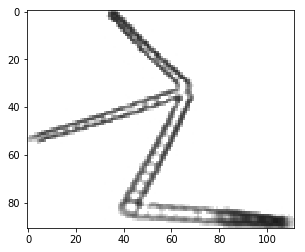

In [ ]:
#Showing an image before resizing
img_test = img_files['imgs/31455302.jpg']
plt.imshow(img_test)
np_arr = np.array(img_test)
print("Shape before :", np_arr.shape)

Shape after : (48, 64)


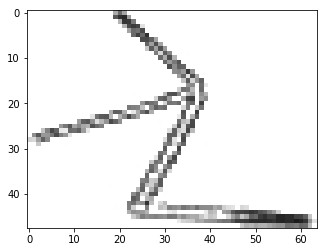

In [ ]:
#Showing the same image after resizing
img_test = img_files['imgs/31455302.jpg'].resize(size)
plt.imshow(img_test)
np_arr = np.array(img_test)
print("Shape after :", np_arr.shape)

<h4> Resizing and loading the images into arrays </h4>

We will load and resize everything in numpy arrays. Our first model being a MultiLayer Perceptron, a single image will be in a single flat array. For a CNN we would have keep the two-dimensions of the images. We will reshape the arrays later for the CNN.

In [ ]:
length_arr = size[0]*size[1]
x, y = [], [] 
start = time()
#Preparing the inputs and labels
list_keys = list(img_files)
for img in list_keys:
    np_arr = np.asarray(img_files[img].resize(size))
    del(img_files[img])
    np_arr = np.reshape(np_arr, length_arr)/255
    #Extract the id to find the corresponding label
    objId = int(re.sub("[^0-9]", "", img))
    level2 = labelL2[labelL2['objid']== objId]['level2'].iloc[0]
    x.append(np_arr)
    y.append(level2)

x = np.asarray(x)
y = np.asarray(y)
print("Time : ", time()-start)

Time :  113.67287397384644


In [ ]:
#freeing some memory
del(list_keys)
del(img_files)
del(meta)
del(labelL2)

<h4> Splitting our data into training and testing set </h4> 

As we do not have a testing set to test our models, we will split our data set. The stratify parameter splits the data in a way so that the proportion of values in the samples produced will be the same as the proportion of values provided to the parameter. This way we are sure that all label classes are represented in the testing set.

We should have done this before the data augmentation process (meaning first load the array, then split, then do some data augmentation on the array) because now we can have some generated images in the testing set, thus we do not ensure that our model generalizes well to (really) unseen data. For that, we can consider that the score of the testing may be a bit higher than if we split the data before data augmentation.

In [ ]:
#Splitting our data in training and testing sets, with a choice of 20% of the data for the test
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

<h4> Encoding the labels </h4>

In [ ]:
#Encoding the labels with the LabelBinarizer
lb = preprocessing.LabelBinarizer()
lb.fit(y)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

In [ ]:
#freeing memory
del(x)
del(y)

In [ ]:
#Printing the sizes
print("Shape x_train", x_train.shape)
print("Shape y_train", y_train.shape)
print("Shape x_test", x_test.shape)
print("Shape y_test", y_test.shape)

Shape x_train (104852, 3072)
Shape y_train (104852, 37)
Shape x_test (26214, 3072)
Shape y_test (26214, 37)


<h4> Standardizing the inputs </h4>

It is still needed to standardize the inputs to make the training less sensitive to the scale of features. We make the mean of the data equals to 0 and the standard deviation equals to 1.

In [ ]:
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()

<h4> Undersampling with ClusterCentroids </h4>

References :
* https://stats.stackexchange.com/questions/166458/rose-and-smote-oversampling-methods
* https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html
* https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

As we said before, we could use SMOTE to over-sample minority class. The problem is that this method will over-sample all classes to have the same number of samples as the majority class (20000*37 samples in total), this will results in a memory error. We could decide to diminish the count of the majority class decided before to apply this over-sampling technique, but we would lose information by randomly deleting images. Therefore we will not do over-sampling.

Instead we will under-sample using a prototype generation technique : cluster centroids.
Prototype generation technique will reduce the number of samples in the targeted classes but the remaining samples are generated — and not selected — from the original set. If we hadn't done data augmentation before, under-sampling would have get us with only a few samples (12\*37 samples in total) because the minority class had only few images. This would have been bad for the performance of the classifier. Now we would expect around 1028\*37=38036 samples in total but weirdly the number of clusters in 1202 which gives a total of 1202\*37=44474 samples. We also see with the warning messages that some classes have possible duplicate due to the manual data augmentation. 

In [ ]:
#prototype generation for under-sampling
start= time()
cc = ClusterCentroids(random_state=5)
x_train, y_train = cc.fit_resample(x_train, y_train)
print("Time : ", time()-start)

/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (384) found smaller than n_clusters (1202). Possibly due to duplicate points in X.
  return_n_iter=True)
/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1033) found smaller than n_clusters (1202). Possibly due to duplicate points in X.
  return_n_iter=True)
/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1138) found smaller than n_clusters (1202). Possibly due to duplicate points in X.
  return_n_iter=True)


In [ ]:
#Printing the sizes
print("Shape x_train", x_train.shape)
print("Shape y_train", y_train.shape)
print("Shape x_test", x_test.shape)
print("Shape y_test", y_test.shape)

Shape x_train (44474, 3072)
Shape y_train (44474, 37)
Shape x_test (29715, 3072)
Shape y_test (29715, 37)


<h4> Saving the data for later use </h4>

Instead of doing all the operations all over again and as the ClusterCentroids algorithm took almost 4 hours, we save the process data so that we just have to load them.

In [ ]:
np.savetxt("x_train.csv", x_train, delimiter=",", fmt='%10f')
np.savetxt("y_train.csv", y_train, delimiter=",", fmt='%d')
np.savetxt("x_test.csv", x_test, delimiter=",", fmt='%10f')
np.savetxt("y_test.csv", y_test, delimiter=",", fmt='%d')

In [ ]:
x_train = np.loadtxt("x_train.csv", delimiter=",") 
y_train = np.loadtxt("y_train.csv", delimiter=",") 
x_test = np.loadtxt("x_test.csv", delimiter=",") 
y_test = np.loadtxt("y_test.csv", delimiter=",") 

<div class="">
    <h3>3. Model Selection</h3>
</div>

There are different ways to deal with this classification problem. We processed the data in a way to use a MultiLayer Perceptron Classifier, we could still reshape the arrays to use a CNN. We could also have use the features. We will compare what could be the advantages/disadvantages of all the models.

References : 
* https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/

<h4> Classifiers using extracted features </h4>

Using the extracted features, we could have used a Decision Trees, Random Forest Classifier, SVC and so on as models. There is no certainty that the model will be more accurate but as we said, it could take into account the size of the images which may be an important feature of a class, indeed we saw that the distribution of the size is largely spread. Furthermore, depending of the number of availables features, it is possible that training the classifier would be faster, there is also less need to do data augmentation than for the use of a NN.
Still, we know that a CNN works very well for image recognition and it is the prefered way to do in this case.

<h4> MultiLayer Perceptron (MLP) </h4>

> They are comprised of one or more layers of neurons. Data is fed to the input layer, there may be one or more hidden layers providing levels of abstraction, and predictions are made on the output layer, also called the visible layer.

> MLPs are suitable for classification prediction problems where inputs are assigned a class or label. They are very flexible and can be used generally to learn a mapping from inputs to outputs.
> This flexibility allows them to be applied to other types of data. For example, the pixels of an image can be reduced down to one long row of data and fed into a MLP. 

Though we know by theory that CNN are more efficient, we first chose to implement a MLP classifier so that we could compare the results.

<h4> Convolutional Neural Network (CNN) </h4>

CNNs work well with data that has a spatial relationship. CNNs are therefore well designed to map image data to an output variable. They are thus more adapted to our problem.
> They have proven so effective that they are the go-to method for any type of prediction problem involving image data as an input.

> The benefit of using CNNs is their ability to develop an internal representation of a two-dimensional image. This allows the model to learn position and scale in variant structures in the data, which is important when working with images.

<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>

Even though a CNN would surely perform better than a MLP, we decided to first try with the MLP classifier and tuning its parameters. We will compare the models at the end.

<h4> Defining the MLP model </h4>

To tune the MLP model, we decided to do some subsets of experiments one after the other instead of using a grid search for example. This is because tuning all the parameters take time, we can better decide to stop rapidly a test when we see that this will not work better than a previous experiments. For clarity we did not let all the tests made. We displayed the loss, the accuracy on training and testing sets as well as the f1_score after some iterations of the MLP classifier to make the comparisons.  We based mostly on the f1_score.

We iterate on the classifier manually setting max_iter to 1 and warm_start to True in a way that we can print the f1_score and other accuracy tests and stop when we think this model is worse than a previous one.
Reference : https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

We tuned the parameters in this order :
* The <b> solver </b> : "adam" (ADAptive Moment) is surely the best parameters because it handles better large data. The tests confirmed it.
* The <b> learning rate </b> : for a learning rate superior to 0.01 the loss can fluctuate and rise rapidly instead of decreasing. A learning rate of 0.0001 looks good but slow a lot the training. We found that a learning rate of 0.0005 works well.
* The <b> activation function </b> : the 'relu' (Rectified Linear Unit) allows the model to converge much more rapidly.
* The <b> hidden layer size </b> : lot of tests give similar results, we tried with maximum 2 hidden layers. The loss decreases more rapidly when there are an important number of neurons (e.g 100 neurons in one hidden layer). With less neurons it still improve similarly but more slowly. Every time, we can see that there is overfitting. Besides, sometimes while the accuracy on training improve, the accuracy on testing as well as the f1-score decrease. We tried also with few neurons (e.g 30 neurons in one hidden layer) to see if reducing it could help for this overfitting but it does not. At the end we found that both models {2 hidden layers : 60 and 40 neurons} and {1 hidden layer : 100 neurons} give similar results. 
> Adding more layers is useful to compute more complex features, going deep seems to be better if the data is very unstructed like for images.

In our case, we got a best f1-score when using 100 neurons in one hidden layer.

We didn't succeed in solving the overfitting problem, we would need more samples for each class. Maybe we should have make more data augmentation before the under-sampling to have more samples for each classes.

We splitted the training into training and validation set, still using stratify even if our dataset is balanced but because we do not have a huge number of samples with regard to our number of classes.

In [ ]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(x_train, y_train, test_size = 0.1, random_state=7, stratify=y_train)

In [ ]:
mlp = MLPClassifier(solver='adam',hidden_layer_sizes=(100), random_state=1, max_iter=1, activation='relu', 
                    learning_rate_init=0.0005, verbose=False, warm_start=True)

In [ ]:
start = time()
previous_f1 = 0
count = 0 #number of times f1_score decrease
for i in range(500):
    mlp.fit(X_train, Y_train)
    y_pred = mlp.predict(X_val)
    f1_score = metrics.f1_score(Y_val, y_pred, average='macro')
    if f1_score-previous_f1<0:
        count+=1
        if count==5:
            print("\nStopping at iteration {} - loss {} - time {}".format(mlp.n_iter_, mlp.loss_, time()-start))
            print("Training set score: %f" % mlp.score(X_train, Y_train))
            print("Validation set score: %f" % mlp.score(X_val, Y_val))
            print("F1_score (average : macro) :", f1_score)
            break
    else:
        count=0
    previous_f1=f1_score
    if i%50==0:
        print("\nIteration {} - loss {} - time {}".format(mlp.n_iter_, mlp.loss_, time()-start))
        print("Training set score: %f" % mlp.score(X_train, Y_train))
        print("Validation set score: %f" % mlp.score(X_val, Y_val))
        print("F1_score (average : macro) :", f1_score)


Iteration 6 - loss 2.689611473128419 - time 6.72345495223999
Training set score: 0.223030
Validation set score: 0.186376
F1_score (average : macro) : 0.2715273912621664

Iteration 56 - loss 1.1636112032418786 - time 347.75076270103455
Training set score: 0.599935
Validation set score: 0.320144
F1_score (average : macro) : 0.4367734948167681

Stopping at iteration 72 - loss 0.9833356892365114 - time 458.34673619270325
Training set score: 0.637386
Validation set score: 0.321942
F1_score (average : macro) : 0.43650905892319913


The training accuracy is not to its possible maximum (we could have easily 99 of accuracy) because we noted that a point the accuracy on the validation decreases while the training accuracy increases. 

In [ ]:
#Results on testing set
y_pred = mlp.predict(x_test)
f1_score = metrics.f1_score(y_test, y_pred, average='macro')
print("\nTesting set score: %f" % mlp.score(x_test, y_test))
print("Test F1_score (average : macro) :", f1_score)


Testing set score: 0.237119
Test F1_score (average : macro) : 0.388457604262404


<h4> CNN </h4>

Based on : https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

For this model, we kept most of the configuration found in a kernel on kaggle, which we will see give already better results than the MLP classifier. We tried to modify some parameters as well as adding some layers (batch normalization layers) but did not have the time to tune it perfectly or trying several architectures.

There are several architectures that we could have tried like the LeNet5 model mentioned in this article : https://medium.com/datadriveninvestor/five-powerful-cnn-architectures-b939c9ddd57b

This CNN is built with keras API (Tensorflow backend). 
For the architecture, we modified what was mandatory to train the CNN on our data : the input and output shapes for example. Furthermore, we added some batch normalization layers as we saw on some articles that it could improve the results. We did not do data augmentation as in the kernel because we already did that manually before. We could have do all the data augmentation part directly before fitting the CNN.

Let us first describe the general architecture by quoting the kaggle's kernel, explain what parameters we could have changed and explain what we added.

<b> Structure of the CNN </b> 
* <b> A convolutional layer </b>
> The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.
> The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

We could have tried to see how removing or adding conv2D layers modify the score of the model. Similarly, the number of filters and the kernel size could be tuned as there may be less/more features to extract from these images.

* <b> A pooling layer </b>
> The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time). The more the pooling dimension is high, the more the downsampling is important.
> Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

As we noticed a strong overfitting in our MLP, the pooling size could be improved to solve this issue. This is another parameter to tune.

* <b> Dropout </b> a regularization method 
> Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their weights to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

Similarly, the proportion of neurons we chose to drop could be tuned to solve the overfitting problem. As we added batch normalization layers, we can wonder if this dropout regularization is still needed.

* <b> Batch Normalization layer </b> 

References : 
* [Using both Dropout and Batch normalization](https://www.quora.com/Should-I-use-a-dropout-layer-if-I-am-using-batch-normalization-in-neural-network-training)
* [Using Batch normalization instead of dropout](https://towardsdatascience.com/dont-use-dropout-in-convolutional-networks-81486c823c16)
* [Order of the layers](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) and [after or before activation](https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras)
    
We found that using a batch normalization layer before or after activation function in Conv2D or Dense layers improve the results. Some says that it should be used instead of dropout as a regularization but most of the time they are both used together in order to improve the results as well as preventing overfitting. We could have tried to see if the dropout layers are still necessary or if indeed they just provide similar regularization.      
There are a lot of debates about if one should use the Batch normalization layer before or after the activation function. We put it after but in all case it must be put before dropout to do well.
    
* <b> A flatten layer </b>
> The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

We need this layer between our conv2D and dense layers.

* <b> The activation function </b> 
> 'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

We could try different activation function, though we already saw that the 'relu' is an optimal function for our problem (for speed of convergence , making sure that we we will not receive values which are lower than 0...). 

* <b> The Dense layers </b> 
> In the end I used the features in two fully-connected (Dense) layers which is just an artificial neural networks (ANN) classifier. In the last layer(Dense(37,activation="softmax")) the net outputs distribution of probability of each class.

We could see how removing/adding dense layers and also modifying the number of units/neurons in each one improve the model. Here, we used more neurons (256) in our hidden layer than in the MLP model (100), we did not looked at how it impacts the CNN results but it sure does.

We kept the final activation ‘softmax’ because it makes the output sum up to 1 so it can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

In [ ]:
#the inputs are matrices
X_train = x_train.reshape(-1,64,48,1) #1 channel B&W
X_test = x_test.reshape(-1,64,48,1) #1 channel B&W
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X_train, y_train, test_size = 0.1, random_state=7)

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (64,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))



model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(37, activation = "softmax"))

<b> Optimizer </b>

> Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

> We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

We also kept the same score function "categorical_crossentropy" as it is the most common choice for classification. We use the ‘accuracy’ metric to see the accuracy score on the validation set when we train the model.

> The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

Thanks to this optimizer we may not have to spend too much time tuning parameters to still have good results.

> I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.



In [ ]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<b> Annealing method </b>
>In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).
>
>The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.
>
>Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
>
>To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).
>
>With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

We changed the 'patience' to 2 so that if after 2 epochs the accuracy does not improve the LR will be reduced by half. We did that because we saw that a very low LR gave better results (and/or avoided a fluctuation) on the MLP classifier.

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

<b> Fitting the model </b>

The number of batch and the number of iterations/epochs could be played with for a trade-off between speed and accuracy.

In [ ]:
history = model.fit(X_train, Y_train, batch_size = 100, epochs = 15, 
                    validation_data = (X_val, Y_val), verbose = 2, callbacks=[learning_rate_reduction])

Train on 40026 samples, validate on 4448 samples
Epoch 1/15
 - 590s - loss: 2.1778 - acc: 0.3774 - val_loss: 2.1277 - val_acc: 0.4148
Epoch 2/15
 - 589s - loss: 1.4669 - acc: 0.5562 - val_loss: 1.7667 - val_acc: 0.4978
Epoch 3/15
 - 590s - loss: 1.1950 - acc: 0.6340 - val_loss: 1.3025 - val_acc: 0.6167
Epoch 4/15
 - 589s - loss: 1.0158 - acc: 0.6860 - val_loss: 1.1360 - val_acc: 0.6509
Epoch 5/15
 - 655s - loss: 0.8803 - acc: 0.7278 - val_loss: 1.2255 - val_acc: 0.6576
Epoch 6/15
 - 697s - loss: 0.7710 - acc: 0.7585 - val_loss: 1.0742 - val_acc: 0.6927
Epoch 7/15
 - 711s - loss: 0.6749 - acc: 0.7831 - val_loss: 1.5491 - val_acc: 0.5845
Epoch 8/15
 - 710s - loss: 0.5898 - acc: 0.8095 - val_loss: 1.3955 - val_acc: 0.6246

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/15
 - 698s - loss: 0.4208 - acc: 0.8649 - val_loss: 0.9701 - val_acc: 0.7217
Epoch 10/15
 - 698s - loss: 0.3605 - acc: 0.8843 - val_loss: 1.0349 - val_acc: 0.7140
Epoch 11/15
 - 699s

<b> Loss and accuracy curves </b>

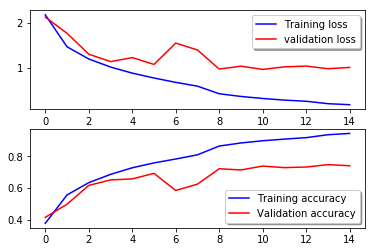

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

We notice fluctuation for the validation accuracy, fortunately the learning rate annealer defined with ReduceLROnPlateau allowed the model to reduce the learning rate and therefore to keep improving.  
There is also overfitting with the validation accuracy stabilizing around 0.74 while the training accuracy keeps rising. 

To compare with the MLP classifier, we can already observe that the validation accuracy (both being 10% of the training set) reached a better level. This is in part due to the fact that we adapted the learning rate during the training in the CNN model and not in the MLP.

<b> Results </b>

In [ ]:
test_score = model.evaluate(X_test,y_test)[1]
print("\nTesting set score: %f" % test_score) 


Testing set score: 0.478916


We had a test score of 0.24 for the MLP. The CNN's accuracy on the test set is thus already way better. 

In [ ]:
y_pred = model.predict(X_test)
y_mod = np.zeros_like(y_pred)  
y_mod[np.arange(len(y_pred)), y_pred.argmax(1)] = 1  #put the maximum probability to 1 and the others to 0
f1_score = metrics.f1_score(y_test, y_mod, average='macro')
print("F1_score (average : macro) :", f1_score)

F1_score (average : macro) : 0.5472343078858358


We have also a better F1_score with the CNN than with the MLP where we  (<b> f1_score 0.39</b>) 

<div class="">
    <h3>5. Model Evaluation</h3>
</div>

Throughout this notebook, we focused on the classification for the level 2. We could try to see how it would do with level 1.

<h4> F1 measure </h4>

Reference : https://www.quora.com/What-are-some-good-error-metrics-for-multi-class-classification-when-you-have-many-objects-to-classify

>A micro-average is generated in a traditional manner: pool all your results into one big contingency table and calculate the F-score from that.

>A macro-average, on the other hand, is obtained by calculating the F-score for each class, and then averaging those to get a single number.

>Because the micro-average gives equal weight to each individual decision, large classes will dominate small ones. This makes it a measure of how effective your classifier is on the large classes in the collection.

>On the other hand, macro-averaging gives equal weight to every class, and so will give you a sense of how effective you are on the small classes.


We used the F1 score to evaluate our model improvement. The macro-average gives the average of the F-score for each class, thus giving equal importance to every class, this way we are sure that the classifier works well on under-represented classes. Yet, as we balanced the data set to have the same amount of samples for each samples and as we use the stratify parameter when splitting the data set, we could think that this is not useful. 

It is hard to say what a good F1 score should be for our problem as our data set was really imbalanced. We must also remember that we may have similar data in the training and testing set as we did the splitting after the data augmentation part, therefore our score may be biased.

<h4> Comparing the models </h4> 

Yet, we can still compare our two models and at the end we get a better F1_score with a CNN (<b> f1_score 0.55 </b>) than with a MLP (<b> f1_score 0.39</b>) and we did not even take the time to try many architectures for the CNN. Indeed, Keras offer a lot of options for the CNN in terms of layers (conv2D, pooling, batch normalizations, dropout...) as well as parameters (the optimizer, the callbacks methods...) and we did not test them all, therefore it would be possible to get an even more better results with more time spent on the model. The processing part (balancing the data set, data augmentation...) could also be improved to get a better F1_score.  

We can therefore say that a CNN is more adequate to solve this problem (and more generally images classification problems) than a MLP classifier. It would have been interesting to compare the results of the CNN with the results from a classifier using the extracted features.

<div class="">
    <h2>Submission</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

In [ ]:
print("F1_score (average : macro) for the CNN model :", f1_score)

F1_score (average : macro) for the CNN model : 0.5472343078858358
